In [7]:
from env.env import sogym
from env.utils import FigureRecorderCallback
import numpy as np
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3 import PPO
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### Environment test and visualization:

In [137]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(mode='train')
eval_env = sogym(mode='test')

In [138]:
# The training environment and the eval environment both have a different boundary conditions distribution:
print("Number of unique BC + desired volume frac combinations in the train distribution: ",len(train_env.BC_dict))
print("Number of unique BC + desired volume frac combinations in the test distribution: ",len(eval_env.BC_dict))

Number of unique BC + desired volume frac combinations in the train distribution:  4284
Number of unique BC + desired volume frac combinations in the test distribution:  2412


Volume:  0.4950675309796909
Reward  [[0.00220833]]


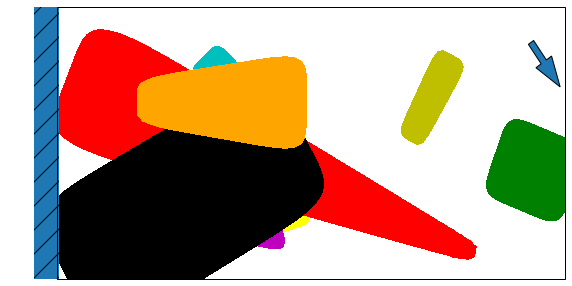

In [139]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, info = train_env.step(action)
print("Volume: ", train_env.volume)
print("Reward ",reward)
train_env.plot()

Volume:  0.6345713766323744
Reward  0.0


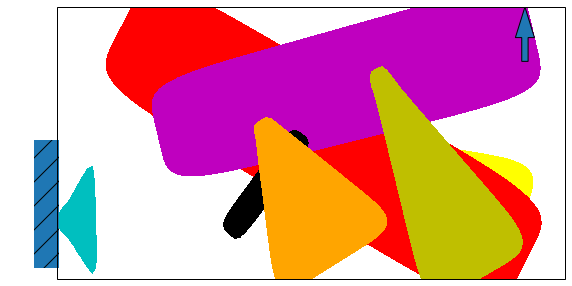

In [140]:
# Let's visualize the eval environment:
obs = eval_env.reset()
done = False
while not done:
    action = eval_env.action_space.sample()
    obs, reward, done, info = eval_env.step(action)
print("Volume: ", eval_env.volume)
print("Reward ",reward)
eval_env.plot()

---
### Multiprocessing

In [4]:
num_cpu = 8 # Number of processes to use
env= make_vec_env(lambda:env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env=VecNormalize(env,gamma=1.0,norm_obs=False)

--- 
### Defining the model

In [5]:
model = PPO("MultiInputPolicy",
            env,
            seed=42,
            n_steps=32,
            batch_size=32,
            verbose=0,
            gamma=1.0,
            tensorboard_log="tb_logs")

--- 
### Training

In [6]:
model.learn(4096*4,
            callback=FigureRecorderCallback(check_freq=8*32),
            tb_log_name='PPO_test')
model.save('model_saved',)
env.save('env_saved.pkl')

---
### Let's visualize the agent's performance:

In [7]:
env=sogym()
env = make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env = VecNormalize.load('env_saved.pkl',env)
env.training=False
env.norm_reward=False

model=model.load('model_saved')
model.set_env(env)

Reward: 0
Volume: 56.8 %


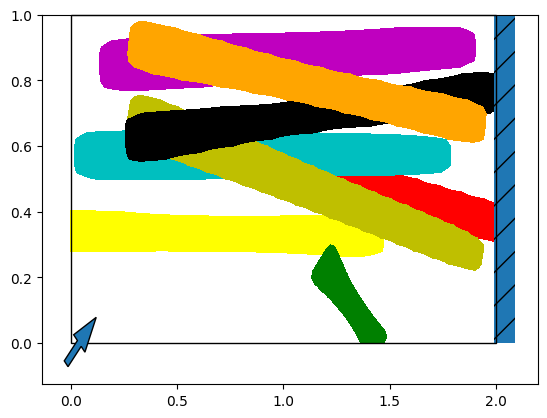

In [18]:
obs=env.reset()
dones=False
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    obs, rewards, dones, info = env.step(np.tanh(action))
print("Reward:",rewards[0])
print("Volume:",np.round(env.get_attr('volume')[0]*100,2),"%")
fig=env.env_method('plot')[0]
fig